# Multi Target Detection In Heavy Tailed Clutter

## Imports

In [4]:
import os
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset

### Wandb

In [5]:
os.environ["WANDB_NOTEBOOK_NAME"] = "Target_Detection.ipynb"
wandb.login(key="a0b9279da3b2e8d45e371d1539a1118e7b82d303")
wandb.init(project="Target_detection-Unet_DAFC_DACK_Diffusion", mode="online")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Target_Detection.ipynb.
wandb: Currently logged in as: ari-granevich. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hawk/.netrc


### Train RD

## Dataset

### Explanation

#### Initialization

Input parameters:
* num_samples: Number of samples in the dataset.
* n_targets: Maximum number of targets per sample (default is 8).
* random_n_targets: If True, the number of targets per sample is random up to n_targets.
* nu: Parameter for the K-distributed clutter (shape parameter of the Gamma distribution).
* scnr: Signal-to-clutter-plus-noise ratio (SCNR) in dB for the targets.

Radar Parameters:
* N = 64: --------------------- Number of fast-time samples per pulse.
* K = 64: --------------------- Number of pulses per frame (slow-time samples).
* B = 50e6: ------------------- Chirp bandwidth (Hz).
* T0 = 1e-3: ------------------ Pulse repetition interval (PRI) in seconds.
* fc = 9.39e9: ---------------- Carrier frequency (Hz).
* c = 3e8: -------------------- Speed of light (m/s).
* CNR = 15: ------------------ Clutter-to-noise ratio in dB.
Range and Doppler Parameters:
* r_min, r_max = 0, 189: ------- Minimum and maximum range (meters).
* v_min, v_max = -7.8, 7.8: ---- Minimum and maximum Doppler velocities (m/s).
* vc_min, vc_max = -7.8, 7.8: -- Clutter velocity range (m/s).
* dr = 3: ---------------------- Range resolution (m).
* dv = 0.249: ----------------- Doppler resolution (m/s).

Range Bins: originaly 64

$$\mathbf{R} = \{ r_{\text{min}}, r_{\text{min}} + \Delta r, \dots, r_{\text{max}} \}$$

Doppler Bins: originaly 64

$$\mathbf{V} = \{ v_{\text{3min}}, v_{\text{min}} + \Delta v, \dots, v_{\text{max}} \}$$

Number of Range and Doppler Bins:
$$d_R = |\mathbf{R}|,\quad d_V = |\mathbf{V}|$$

Noise Power $\sigma^2$ :

$$\text{CNR}_{\text{linear}} = 10^{\frac{\text{CNR}_{\text{dB}}}{10}}$$

$$\sigma^2 = \frac{N}{2 \cdot \text{CNR}_{\text{linear}}}$$

Normalization Constant $\text{cn\_norm}$:

$$\text{cn\_norm} = \sqrt{N \cdot K \cdot \left( \frac{N}{2} + \sigma^2 \right)}$$

#### Generate target signal
1. Compute the range steering vector:
$$w_r = \frac{2 \pi \cdot 2 \cdot B \cdot \text{ranges}}{c \cdot N}$$

The range steering vector is then calculated as:

$$\text{range\_steering} = e^{-j \cdot w_r \cdot \text{arange}(N)}$$


2. Compute the velocity steering vector:
$$w_d = \frac{2 \pi \cdot T_0 \cdot 2 \cdot f_c \cdot \text{velocities}}{c}$$

The velocity steering vector is then calculated as:

$$\text{velocity\_steering} = e^{-j \cdot w_d \cdot \text{arange}(K)}$$

3. Combine the range and Doppler steering vectors:

$$ rd\_signal= range\_steering * velocity\_steering$$

Shape: $$Num\_targets \times N \times K$$

4. apply random phases for targets:

$$ rd\_signal = rd_signal * e^{j*phases}$$

5. prepare for scaling: Compute the norm of the signal for each target:

$$ S\_norm = ||rd_signal||$$

$$ sig\_amp = 10^{SCNR\_DB/20} \cdot \frac{cn\_norm}{S\_norm}$$

6. Scale and sum the signals for all targets into a single matrix:
$$
\text{rd\_signal} = \sum_{\text{targets}} \left( \text{sig\_amp} \cdot \text{rd\_signal} \right)
$$

7. The final output is a matrix:
$$
\text{rd\_signal} \in \mathbb{C}^{N \times K}
$$


#### Generate clutter

This function generates K-distributed SIRV (Spherically Invariant Random Vector) clutter using eigendecomposition.

The clutter velocity is sampled uniformly:
$$
\text{clutter\_vel} \sim U(\text{vc\_min}, \text{vc\_max})
$$

The Doppler shift of the clutter is computed as:
$$
f_d = \frac{2 \pi \cdot 2 \cdot f_c \cdot \text{clutter\_vel}}{c}
$$

The correlation matrix $ M $ is generated using:
$$
M_{p,q} = e^{\left(-2 \pi^2 \sigma_f^2 (p - q)^2 - j (p - q) f_d T_0 \right)}
$$
where $\sigma_f$ is a fixed parameter from the paper.

Complex Normal Samples


Generate complex normal samples $z$:
$$
z \sim \mathcal{CN}(0, \frac{1}{2})
$$
with shape $(K \times d_R)$.

Eigenvalue Decomposition:


Perform eigenvalue decomposition on  $M$:
$$
M = V \Lambda V^\dagger
$$

The square root of eigenvalues is computed:
$$
E = \text{diag}(\sqrt{\max(\lambda, 0)})
$$

The clutter time-domain weights are computed as:
$$
w_t = A z \quad \text{where } A = V E
$$

Texture Component:


The texture component $ s $ is sampled from a Gamma distribution:
$$
s \sim \text{Gamma}(\nu, \nu)
$$

Scale the clutter weights by the texture component:
$$
c_t = \sqrt{s} \cdot w_t
$$

Fast-Time × Slow-Time Representation:

The fast-time steering vector $c_{r\_steer}$ is computed as:
$$
c_{r\_steer} = \exp\left(-j \cdot 2 \pi \cdot \text{arange}(N) \cdot R \cdot \frac{2 B}{c \cdot N}\right)
$$

The final clutter matrix $C$ is obtained by:
$$
C = c_{r\_steer} \cdot c_t^T
$$


The function returns the clutter matrix $ C $:
$$
C \in \mathbb{C}^{N \times K}
$$


#### Generate frame and labels

This function generates a radar frame containing noise, clutter, and optionally targets, along with a label matrix identifying the target locations in the range-Doppler plane.

1. Generate Noise

   The noise matrix $ W $ is generated as:
   $$
   W \sim \mathcal{CN}\left(0, \frac{1}{2 \sigma^2}\right), \quad W \in \mathbb{C}^{N \times K}
   $$

2. Generate Clutter

   The clutter texture parameter $ \nu $ is sampled as:
   $$
   \nu \sim U(0.1, 1.5)
   $$  
   if $ \nu $ is not provided. Otherwise, it is set to the user-defined value.  
   The clutter matrix $ C $ is then generated using:
   $$
   C = \text{generate\_clutter}(\nu)
   $$

3. Initialize Target Signal and Label Matrices

   - Initialize the target signal matrix $ S $ with zeros:
     $$
     S = \mathbf{0}, \quad S \in \mathbb{C}^{N \times K}
     $$
   - Initialize the label matrix $ \text{rd\_label} $ with zeros:
     $$
     \text{rd\_label} = \mathbf{0}, \quad \text{rd\_label} \in \{0, 1\}^{d_R \times d_V}
     $$

4. Generate Targets (if applicable) 

   If targets are enabled, the following steps are performed:
   - Sample the number of targets $ n $:
     $$
     n \sim U(1, \text{n\_targets})
     $$  
     if $ \text{random\_n\_targets} $ is enabled. Otherwise, $ n $ is fixed to $ \text{n\_targets} $.
   - Sample the target ranges, velocities, phases, and SCNR values:
     $$
     \text{ranges} \sim U(r_\text{min}, r_\text{max})
     $$
     $$
     \text{velocities} \sim U(v_\text{min}, v_\text{max})
     $$
     $$
     \text{phases} \sim U(0, 2 \pi)
     $$
     $$
     \text{SCNR\_dBs} \sim U(-5, 10)
     $$  
     if $ \text{scnr} $ is not provided. Otherwise, SCNR is set to a constant value.

   - Generate the target signal matrix $ S $:
     $$
     S = \text{generate\_target\_signal}(\text{ranges}, \text{velocities}, \text{phases}, \text{SCNR\_dBs})
     $$

   - Populate the label matrix $ \text{rd\_label} $:  
     For each target, determine the nearest range bin $ r_\text{bin} $ and Doppler bin $ v_\text{bin} $:
     $$
     r_\text{bin} = \arg\min |R - r|, \quad v_\text{bin} = \arg\min |V - v|
     $$
     Set:
     $$
     \text{rd\_label}[r_\text{bin}, v_\text{bin}] = 1
     $$

5. Combine Signals

   The final radar frame $ X $ is the sum of the target signal, clutter, and noise:
   $$
   X = S + C + W
   $$

6. Return  

   The function returns:
   $$
   X \in \mathbb{C}^{N \times K}, \quad \text{rd\_label} \in \{0, 1\}^{d_R \times d_V}
   $$


### Code

In [6]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 8, random_n_targets=True, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        self.nu = torch.tensor([nu]) if nu is not None else None

        # Parameters
        self.N = 64  # Samples per pulse (fast-time)
        self.K = 64  # Pulses per frame (slow-time)
        self.B = 50e6  # Chirp bandwidth (Hz)
        self.T0 = 1e-3  # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8  # Speed of light (m/s)
        self.CNR = 15  # Clutter-to-noise ratio (dB)

        # Range and Doppler parameters
        self.r_min, self.r_max = 0, 189  # Range interval (m)
        self.v_min, self.v_max = -7.8, 7.8  # Doppler interval (m/s)
        self.vc_min, self.vc_max = -7.8, 7.8  # Clutter min/max velocity (m/s)
        self.dr = 3  # Range resolution (m)
        self.dv = 0.249  # Doppler resolution (m/s)

        # Calculate range and Doppler bins
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)  # Number of range bins
        self.dV = len(self.V)  # Number of Doppler bins

        # Noise power calculation
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10)) 
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2)))

        # Precompute the range steering matrix for matched filtering.
        # This acts as the matched filter in the range dimension.
        # For a linear FM chirp, the matched filter corresponds to the conjugate of the transmitted signal.
        # Here, we assume a uniform linear frequency modulation and use a steering vector based on the range bins.
        # range_steering_full will have dimensions (dR x N).
        w_range = (2 * torch.pi * (2 * self.B) / (self.c * self.N)) * self.R.unsqueeze(-1) * torch.arange(self.N)
        # w_range: dR x N
        self.range_steering_full = torch.exp(-1j * w_range)

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        # Range steering vector
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N)))

        # Doppler steering vector
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K)))
        
        # Fast-time x Slow-time matrix
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)

        # Random phase for each target
        rd_signal = rd_signal * torch.exp(1j * phases)

        # Scaling SCNR for each target
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)

        return rd_signal

    def generate_clutter(self, nu):
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = (2 * torch.pi * (2 * self.fc * clutter_vel) / self.c) 
        sigma_f = 0.05  # From the referenced paper
        p, q = torch.meshgrid(torch.arange(self.N),
                              torch.arange(self.K), indexing='ij')
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * (p - q) * fd * self.T0)
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))

        e, V = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.maximum(e.real, torch.tensor(0.0)))
        E = torch.diag(e_sqrt)
        A = V @ E.to(V.dtype)
        w_t = A @ z

        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast-time × slow-time representation
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N), self.R) * (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        # Generate Noise
        W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0 * self.sigma2)))

        # Generate Clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)

        # Initialize target signal and label matrices
        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)
        if self.with_targets:
            n = torch.randint(1, self.n_targets + 1, (1,)) if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)

            # Create label matrix
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        return S, C, W, rd_label

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        S, C, W, rd_label = self.gen_frame_and_labels()
        X = S+C+W
        IQ_map = X
        X_range = self.range_steering_full.conj() @ X     
        S_range = self.range_steering_full.conj() @ S

        S_RD = torch.fft.fft(S_range, dim=1)
        S_RD = torch.fft.fftshift(S_RD, dim=1)
        S_RD_magnitude = S_RD#.abs()
        clean_RD_map = S_RD_magnitude.flip(dims=[1])

        X_RD = torch.fft.fft(X_range, dim=1)
        X_RD = torch.fft.fftshift(X_RD, dim=1)

        X_RD_magnitude = X_RD#.abs()
        RD_map = X_RD_magnitude.flip(dims=[1]) 
        return S, C, IQ_map, clean_RD_map, RD_map, rd_label

In [7]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

IQ_map type: torch.ComplexFloatTensor
RD_map type: torch.ComplexFloatTensor
Slow time x Fast time map shape: torch.Size([64, 64])
Range-Doppler map shape: torch.Size([64, 64])
Label shape: torch.Size([64, 64])


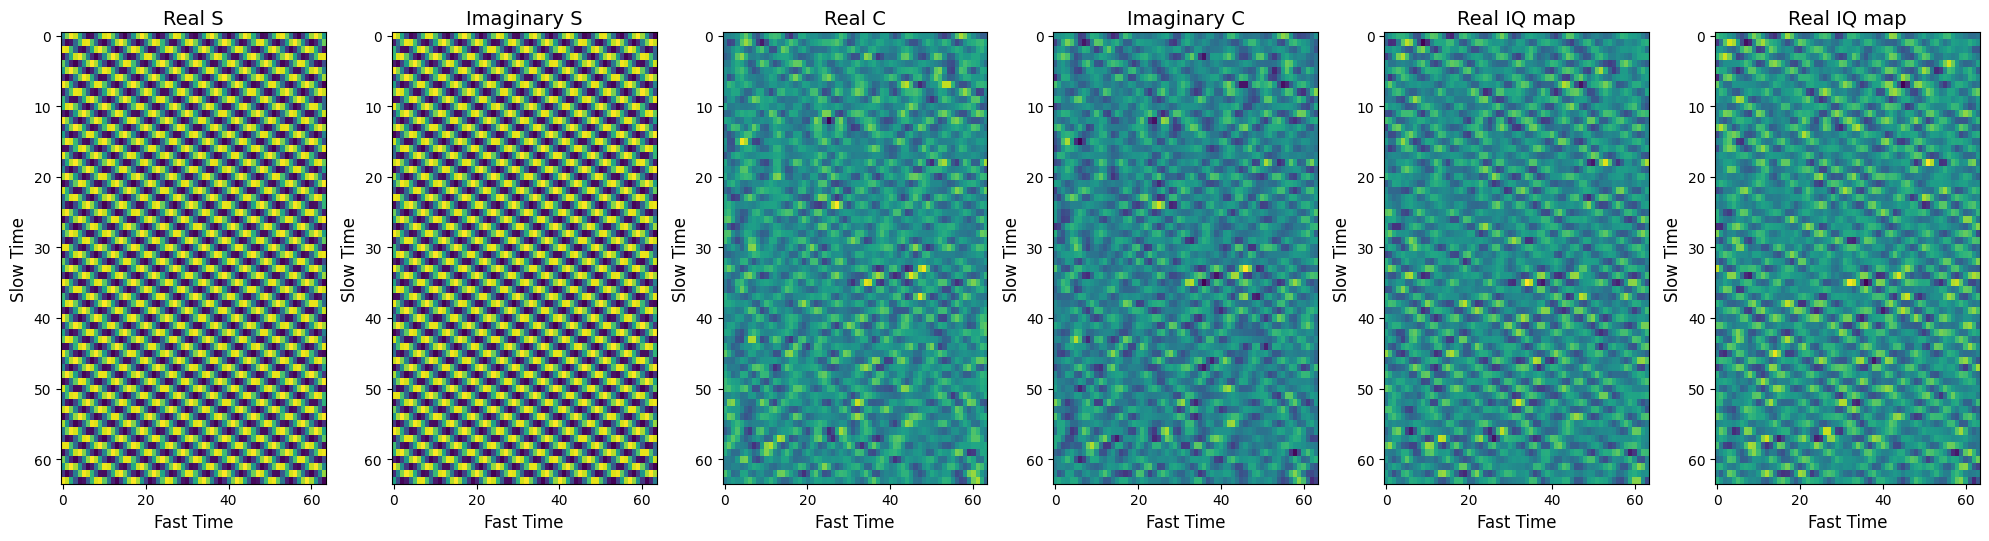

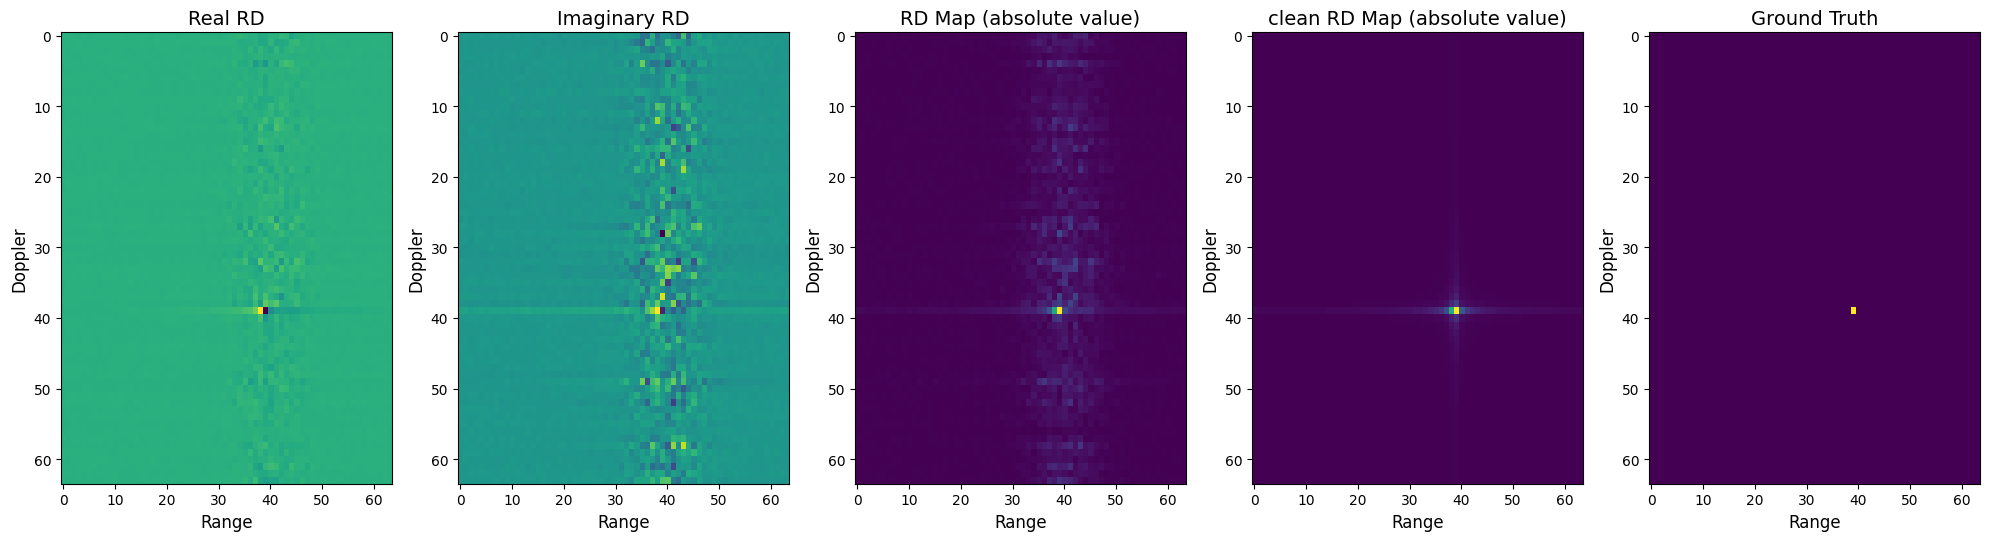

In [8]:
S, C, IQ_map, clean_RD_map, RD_map, RD_label = train_dataset_with_targets[1]

# Print some debug/reference information
print(f"IQ_map type: {IQ_map.type()}")
print(f"RD_map type: {RD_map.type()}")
print(f"Slow time x Fast time map shape: {IQ_map.shape}")
print(f"Range-Doppler map shape: {RD_map.shape}")
print(f"Label shape: {RD_label.shape}")

# Create a figure with five subplots in one row
plt.figure(figsize=(20, 6))

# Subplot 1: Real part of IQ data
plt.subplot(1, 6, 1)
plt.imshow(torch.real(S), aspect='auto', cmap='viridis')
plt.title("Real S", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 2: Imaginary part of IQ data
plt.subplot(1, 6, 2)
plt.imshow(torch.imag(S), aspect='auto', cmap='viridis')
plt.title("Imaginary S", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)
# Subplot 3: Magnitude of X_range
plt.subplot(1, 6, 3)
plt.imshow(torch.real(C) , aspect='auto', cmap='viridis')
plt.title("Real C", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 4: Magnitude of the Range-Doppler map
plt.subplot(1, 6, 4)
plt.imshow(torch.imag(C), aspect='auto', cmap='viridis')
plt.title("Imaginary C", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 5: Range-Doppler label (ground truth)
plt.subplot(1, 6, 5)
plt.imshow(torch.real(IQ_map), aspect='auto', cmap='viridis')
plt.title("Real IQ map", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

plt.subplot(1, 6, 6)
plt.imshow(torch.imag(IQ_map), aspect='auto', cmap='viridis')
plt.title("Real IQ map", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Adjust the layout, save, and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("maps")
plt.show()

plt.figure(figsize=(20, 6))

# Subplot 1: Real part of IQ data
plt.subplot(1, 5, 1)
plt.imshow(torch.real(RD_map), aspect='auto', cmap='viridis')
plt.title("Real RD", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Subplot 1: Real part of IQ data
plt.subplot(1, 5, 2)
plt.imshow(torch.imag(RD_map), aspect='auto', cmap='viridis')
plt.title("Imaginary RD", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

plt.subplot(1, 5, 3)
plt.imshow(torch.abs(RD_map), aspect='auto', cmap='viridis')
plt.title("RD Map (absolute value)", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

plt.subplot(1, 5, 4)
plt.imshow(torch.abs(clean_RD_map), aspect='auto', cmap='viridis')
plt.title("clean RD Map (absolute value)", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Subplot 2: Imaginary part of IQ data
plt.subplot(1, 5, 5)
plt.imshow(RD_label, aspect='auto', cmap='viridis')
plt.title("Ground Truth", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Adjust the layout, save, and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("maps")
plt.show()


## U-net

### Model definition

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        current_channels = in_channels
        for feature in features:
            self.downs.append(DoubleConv(current_channels, feature))
            current_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode="bilinear", align_corners=True)
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](x)

        return self.final_conv(x)  


### Custom loss

In [7]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels

    Args:
        train_loader: DataLoader for the training set
        detection_type: "range" or "doppler"
    
    Returns:
        ratio: The fraction of bins that contain targets
    """
    n1 = 0  # Count of bins with targets
    n_total = len(train_loader.dataset) * 64  # Adjust if your range-doppler map size is different

    for _, _, _, _, _, rd_label in train_loader:
        # rd_label is [B, dR, dV]
        # If detection_type == "range", sum over Doppler dimension (-1)
        # If detection_type == "doppler", sum over Range dimension (-2)
        
        if detection_type == "range":
            # Sum over Doppler dimension (last dimension)
            label = (rd_label.sum(dim=-1) >= 1).float()
        else:
            # Sum over Range dimension (second last dimension)
            label = (rd_label.sum(dim=-2) >= 1).float()

        # Count how many bins are positive
        n1 += torch.sum(label >= 0.9999)

    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


In [8]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss for logits.
        
        Args:
            ratio: Ratio of positive samples (e.g., #positives / total_samples).
            beta: Beta parameter for class balancing.
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("CBBCE weight for positives: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Args:
            y_pred: [B, N*K] logits
            y_true: [B, N*K] target (0 or 1)
        """
        # Compute element-wise BCE with logits
        _nll2 = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        
        # Identify positive samples
        # y_true is either 0 or 1. If exact 1 may be used:
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Indices of positives
        
        # Weight the positive samples
        if ind1.numel() > 0:
            _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]
            _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)
        
        # Mean loss
        loss = torch.mean(_nll2)
        return loss


### Train IQ

ratio: 0.03391342163085938 , n1: 44451 , n_total: 1310720
CBBCE weight for positives:  29.3441697598943
Epoch 1/200
Train Loss: 0.2429, Train Acc: 0.9751
Val Loss: 0.1308,   Val Acc: 0.9995
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 2/200
Train Loss: 0.1012, Train Acc: 0.9994
Val Loss: 0.0858,   Val Acc: 0.9995
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 3/200
Train Loss: 0.0812, Train Acc: 0.9994
Val Loss: 0.0776,   Val Acc: 0.9994
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 4/200
Train Loss: 0.0759, Train Acc: 0.9994
Val Loss: 0.0754,   Val Acc: 0.9994
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 5/200
Train Loss: 0.0733, Train Acc: 0.9994
Val Loss: 0.0729,   Val Acc: 0.9994
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val Dice: 0.0000
Epoch 6/200
Train Loss: 0.0710, Train Acc: 0.9995
Val Loss: 0.0720,   Val Acc: 0.9994


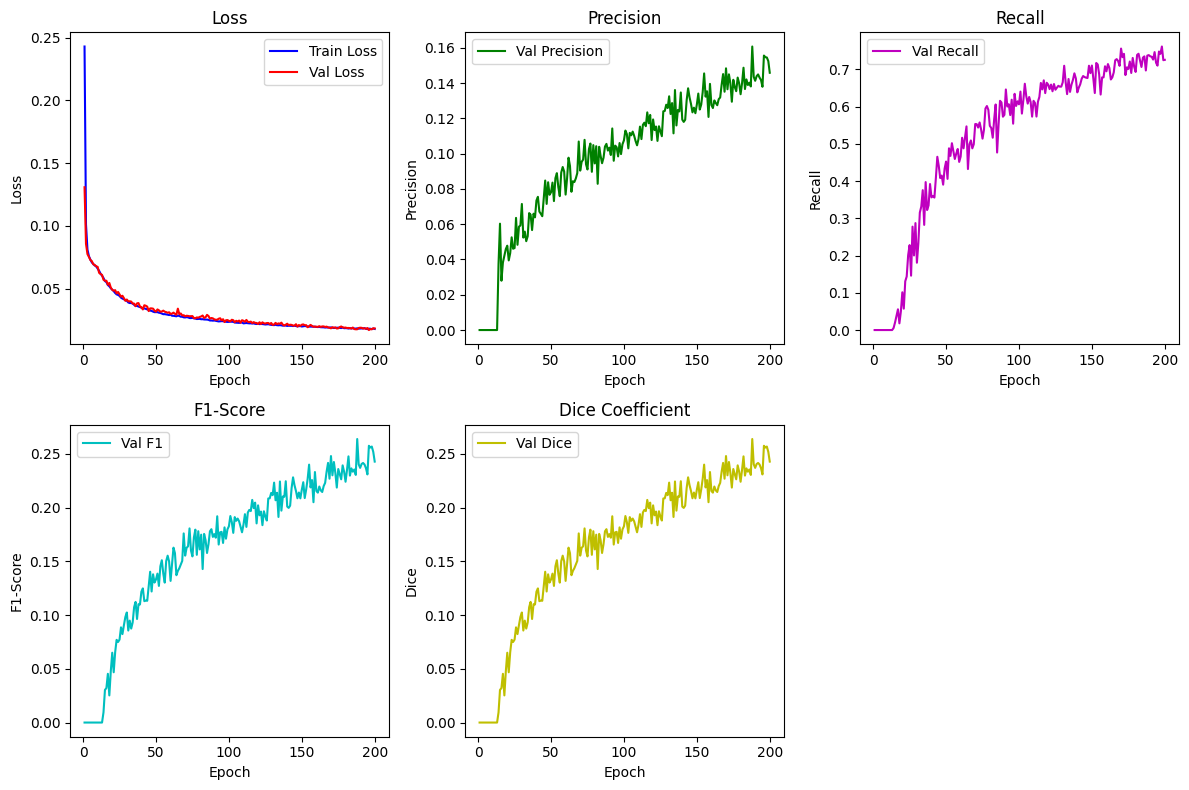

In [9]:
def compute_metrics(pred_mask, rd_label, eps=1e-8):
    pred_mask = pred_mask.bool()
    rd_label = rd_label.bool()

    tp = (pred_mask & rd_label).sum().item()
    fp = (pred_mask & ~rd_label).sum().item()
    fn = (~pred_mask & rd_label).sum().item()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * (precision * recall) / (precision + recall + eps)
    dice = (2 * tp) / (2*tp + fp + fn + eps)

    return precision, recall, f1, dice

# detection_type for ratio calculation
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)

model = UNet(in_channels=2, out_channels=1).cuda()
criterion = CBBCE(ratio=ratio)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 200

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_precisions = []
val_recalls = []
val_f1s = []
val_dices = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        S, C, IQ_map, clean_RD_map, RD_map, rd_label = batch

        # Prepare inputs for IQ map
        IQ_map_real = IQ_map.real.unsqueeze(1).cuda()  # [B, 1, N, K]
        IQ_map_imag = IQ_map.imag.unsqueeze(1).cuda()
        IQ_map_input = torch.cat([IQ_map_real, IQ_map_imag], dim=1) # [B, 2, N, K]

        rd_label = rd_label.unsqueeze(1).float().cuda() # [B, 1, N, K]

        # Forward pass
        y_pred_logits = model(IQ_map_input)  # [B, 1, N, K] logits
        B, C, H, W = y_pred_logits.shape
        y_pred_flat = y_pred_logits.view(B, H*W)
        y_true_flat = rd_label.view(B, H*W)

        loss = criterion(y_pred_flat, y_true_flat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * B

        with torch.no_grad():
            pred_probs = torch.sigmoid(y_pred_logits)
            pred_mask = (pred_probs > 0.5).float()
            correct = (pred_mask == rd_label).sum().item()
            total = rd_label.numel()
            train_correct += correct
            train_total += total

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_tp, val_fp, val_fn = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            S, C, IQ_map, clean_RD_map, RD_map, rd_label = batch
            IQ_map_real = IQ_map.real.unsqueeze(1).cuda()
            IQ_map_imag = IQ_map.imag.unsqueeze(1).cuda()
            IQ_map_input = torch.cat([IQ_map_real, IQ_map_imag], dim=1)

            rd_label = rd_label.unsqueeze(1).float().cuda()

            y_pred_logits = model(IQ_map_input)
            B, C, H, W = y_pred_logits.shape
            y_pred_flat = y_pred_logits.view(B, H*W)
            y_true_flat = rd_label.view(B, H*W)

            loss = criterion(y_pred_flat, y_true_flat)
            val_loss += loss.item() * B

            pred_probs = torch.sigmoid(y_pred_logits)
            pred_mask = (pred_probs > 0.5).float()
            correct = (pred_mask == rd_label).sum().item()
            total = rd_label.numel()
            val_correct += correct
            val_total += total

            # Compute TP, FP, FN for val
            pred_bool = pred_mask.bool()
            gt_bool = rd_label.bool()
            val_tp += (pred_bool & gt_bool).sum().item()
            val_fp += (pred_bool & ~gt_bool).sum().item()
            val_fn += (~pred_bool & gt_bool).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_precision, val_recall, val_f1, val_dice = compute_metrics(pred_mask, rd_label)

    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    val_dices.append(val_dice)

    wandb.log({
        "IQ_unet/train_loss": train_loss,
        "IQ_unet/val_loss": val_loss,
        "IQ_unet/val_precision": val_precision,
        "IQ_unet/val_recall": val_recall,
        "IQ_unet/val_f1": val_f1,
        "IQ_unet/val_dice": val_dice,
        "epoch": epoch + 1,
    })
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f},   Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}, Val Dice: {val_dice:.4f}")

    # Scheduler step - based on validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save best model so far
        torch.save(model.state_dict(), "IQ_unet.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation loss: ", best_val_loss)

# Plotting the metrics
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_precisions, 'g', label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, val_recalls, 'm', label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, val_f1s, 'c', label='Val F1')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, val_dices, 'y', label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()


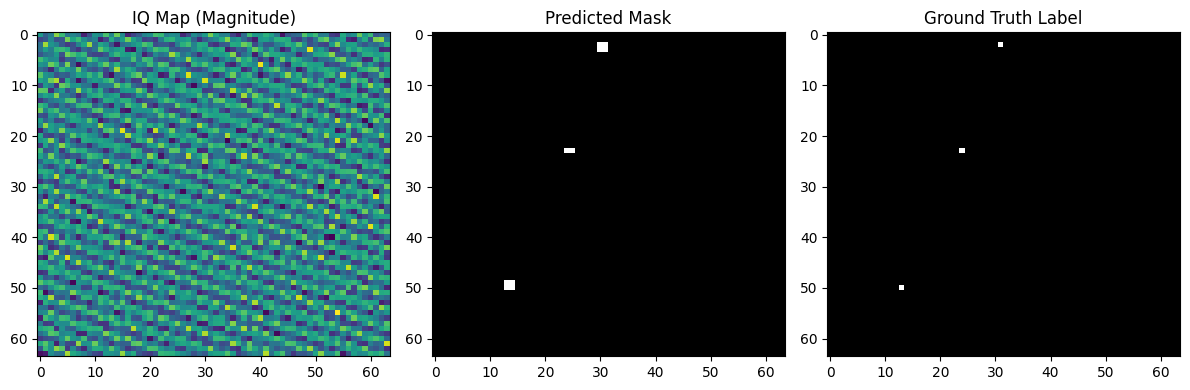

In [10]:
model.eval()
with torch.no_grad():
    S, C, IQ_map, clean_RD_map, RD_map, rd_label = train_dataset[0]

    IQ_map_real = IQ_map.real.unsqueeze(0).unsqueeze(1).cuda()
    IQ_map_imag = IQ_map.imag.unsqueeze(0).unsqueeze(1).cuda()
    IQ_map_input = torch.cat([IQ_map_real, IQ_map_imag], dim=1) # [1, 2, N, K]

    y_pred_logits = model(IQ_map_input)  # [1, 1, N, K]
    pred_probs = torch.sigmoid(y_pred_logits)  # Convert logits to probabilities
    pred_mask = (pred_probs > 0.5).float().cpu().squeeze(0).squeeze(0) # [N, K]

IQ_map_magnitude = IQ_map.abs()
rd_label_cpu = rd_label.cpu()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(IQ_map_magnitude, aspect='auto', cmap='viridis')
axs[0].set_title('IQ Map (Magnitude)')

axs[1].imshow(pred_mask, aspect='auto', cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Predicted Mask')

axs[2].imshow(rd_label_cpu, aspect='auto', cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Ground Truth Label')

plt.tight_layout()
plt.show()


ratio: 0.03386611938476562 , n1: 44389 , n_total: 1310720
CBBCE weight for positives:  29.38514902254786
Epoch 1/200
Train Loss: 0.1805, Train Acc: 0.9924
Val Loss: 0.0652,   Val Acc: 0.9995
Val Precision: 0.5564, Val Recall: 0.9890, Val F1: 0.7121, Val Dice: 0.7121
Epoch 2/200
Train Loss: 0.0391, Train Acc: 0.9997
Val Loss: 0.0243,   Val Acc: 0.9997
Val Precision: 0.6688, Val Recall: 0.9773, Val F1: 0.7942, Val Dice: 0.7942
Epoch 3/200
Train Loss: 0.0170, Train Acc: 0.9998
Val Loss: 0.0130,   Val Acc: 0.9998
Val Precision: 0.6793, Val Recall: 0.9914, Val F1: 0.8062, Val Dice: 0.8062
Epoch 4/200
Train Loss: 0.0097, Train Acc: 0.9998
Val Loss: 0.0079,   Val Acc: 0.9998
Val Precision: 0.7500, Val Recall: 0.9912, Val F1: 0.8539, Val Dice: 0.8539
Epoch 5/200
Train Loss: 0.0064, Train Acc: 0.9998
Val Loss: 0.0056,   Val Acc: 0.9998
Val Precision: 0.7176, Val Recall: 0.9966, Val F1: 0.8344, Val Dice: 0.8344
Epoch 6/200
Train Loss: 0.0046, Train Acc: 0.9998
Val Loss: 0.0039,   Val Acc: 0.9998

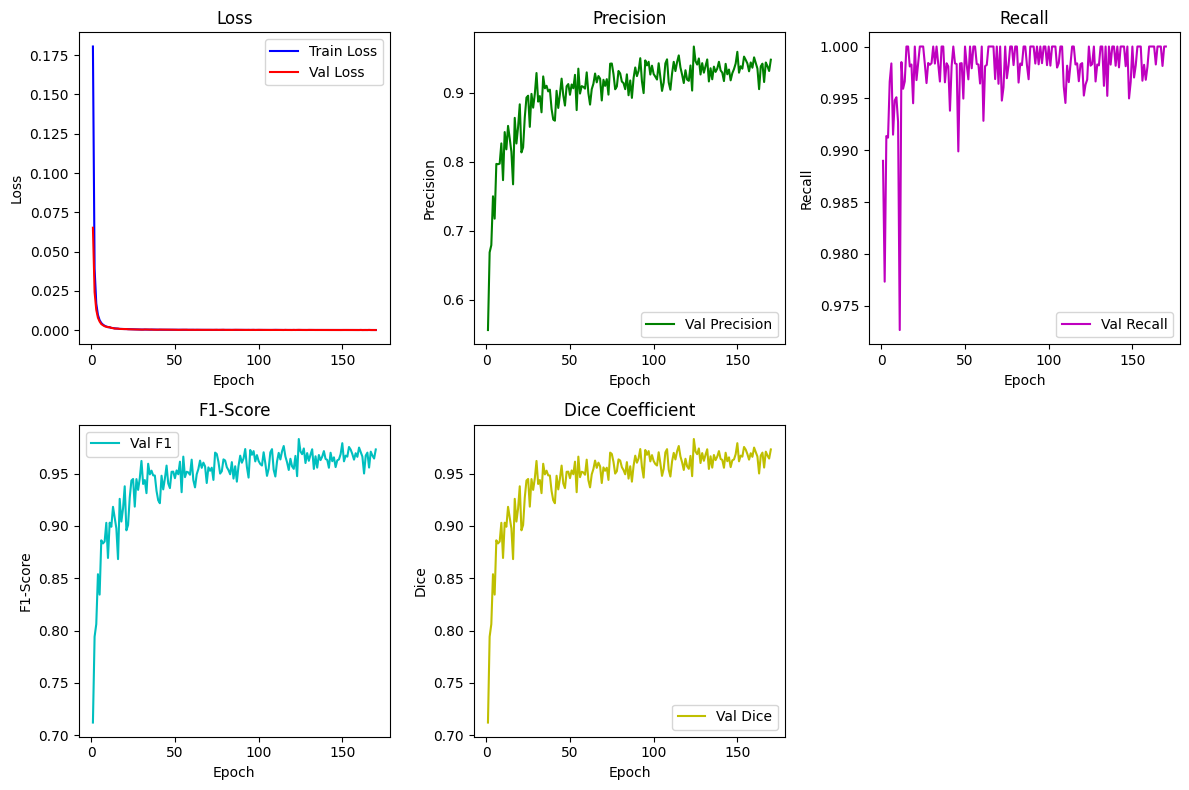

In [11]:
def compute_metrics(pred_mask, rd_label, eps=1e-8):
    pred_mask = pred_mask.bool()
    rd_label = rd_label.bool()

    tp = (pred_mask & rd_label).sum().item()
    fp = (pred_mask & ~rd_label).sum().item()
    fn = (~pred_mask & rd_label).sum().item()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * (precision * recall) / (precision + recall + eps)
    dice = (2 * tp) / (2*tp + fp + fn + eps)

    return precision, recall, f1, dice

# detection_type for ratio calculation
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)

model = UNet(in_channels=2, out_channels=1).cuda()
criterion = CBBCE(ratio=ratio)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 200

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_precisions = []
val_recalls = []
val_f1s = []
val_dices = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        S, C, IQ_map, clean_RD_map, RD_map, rd_label = batch

        # Prepare inputs for IQ map
        RD_map_real = RD_map.real.unsqueeze(1).cuda()  # [B, 1, N, K]
        RD_map_imag = RD_map.imag.unsqueeze(1).cuda()
        RD_map_input = torch.cat([RD_map_real, RD_map_imag], dim=1) # [B, 2, N, K]

        rd_label = rd_label.unsqueeze(1).float().cuda() # [B, 1, N, K]

        # Forward pass
        y_pred_logits = model(RD_map_input)  # [B, 1, N, K] logits
        B, C, H, W = y_pred_logits.shape
        y_pred_flat = y_pred_logits.view(B, H*W)
        y_true_flat = rd_label.view(B, H*W)

        loss = criterion(y_pred_flat, y_true_flat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * B

        with torch.no_grad():
            pred_probs = torch.sigmoid(y_pred_logits)
            pred_mask = (pred_probs > 0.5).float()
            correct = (pred_mask == rd_label).sum().item()
            total = rd_label.numel()
            train_correct += correct
            train_total += total

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_tp, val_fp, val_fn = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            S, C, IQ_map, clean_RD_map, RD_map, rd_label = batch
            RD_map_real = RD_map.real.unsqueeze(1).cuda()
            RD_map_imag = RD_map.imag.unsqueeze(1).cuda()
            RD_map_input = torch.cat([RD_map_real, RD_map_imag], dim=1)

            rd_label = rd_label.unsqueeze(1).float().cuda()

            y_pred_logits = model(RD_map_input)
            B, C, H, W = y_pred_logits.shape
            y_pred_flat = y_pred_logits.view(B, H*W)
            y_true_flat = rd_label.view(B, H*W)

            loss = criterion(y_pred_flat, y_true_flat)
            val_loss += loss.item() * B

            pred_probs = torch.sigmoid(y_pred_logits)
            pred_mask = (pred_probs > 0.5).float()
            correct = (pred_mask == rd_label).sum().item()
            total = rd_label.numel()
            val_correct += correct
            val_total += total

            # Compute TP, FP, FN for val
            pred_bool = pred_mask.bool()
            gt_bool = rd_label.bool()
            val_tp += (pred_bool & gt_bool).sum().item()
            val_fp += (pred_bool & ~gt_bool).sum().item()
            val_fn += (~pred_bool & gt_bool).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_precision, val_recall, val_f1, val_dice = compute_metrics(pred_mask, rd_label)

    # Append metrics to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    val_dices.append(val_dice)

    wandb.log({
        "RD_unet/train_loss": train_loss,
        "RD_unet/val_loss": val_loss,
        "RD_unet/val_precision": val_precision,
        "RD_unet/val_recall": val_recall,
        "RD_unet/val_f1": val_f1,
        "RD_unet/val_dice": val_dice,
        "epoch": epoch + 1,
    })

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f},   Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}, Val Dice: {val_dice:.4f}")

    # Scheduler step - based on validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save best model so far
        torch.save(model.state_dict(), "RD_unet.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered.")
            break

print("Training complete. Best validation loss: ", best_val_loss)

# Plotting the metrics
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_precisions, 'g', label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, val_recalls, 'm', label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, val_f1s, 'c', label='Val F1')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, val_dices, 'y', label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()


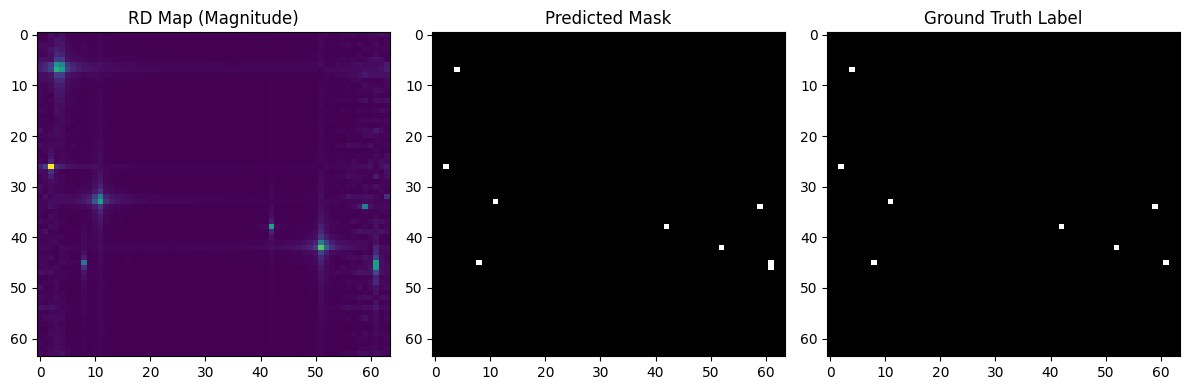

In [12]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    S, C, IQ_map, clean_RD_map, RD_map, rd_label = train_dataset[0]

    RD_map_real = RD_map.real.unsqueeze(0).unsqueeze(1).cuda()
    RD_map_imag = RD_map.imag.unsqueeze(0).unsqueeze(1).cuda()
    RD_map_input = torch.cat([RD_map_real, RD_map_imag], dim=1) # [1, 2, N, K]

    y_pred_logits = model(RD_map_input)  # [1, 1, N, K]
    pred_probs = torch.sigmoid(y_pred_logits)  # Convert logits to probabilities
    pred_mask = (pred_probs > 0.5).float().cpu().squeeze(0).squeeze(0) # [N, K]

RD_map_magnitude = RD_map.abs()
rd_label_cpu = rd_label.cpu()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].imshow(RD_map_magnitude, aspect='auto', cmap='viridis')
axs[0].set_title('RD Map (Magnitude)')

axs[1].imshow(pred_mask, aspect='auto', cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Predicted Mask')

axs[2].imshow(rd_label_cpu, aspect='auto', cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Ground Truth Label')

plt.tight_layout()
plt.show()


## DAFC-DACK

### Preprocessing

In [12]:
class RadarPreprocessing(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        Preprocessing module as described in Section III.B

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()
        self.detection_type = detection_type

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch, N, K, 2) - real and imaginary parts stacked in last dimension
        # Step 1: Reshape input based on detection type
        if self.detection_type == "range":
            X_0 = X.transpose(1, 2)  # (batch, K, N)
        else:  # doppler
            X_0 = X  # (batch, N, K)
        # Step 2: Center features over rows
        X_mean = torch.mean(X_0, dim=1, keepdim=True)
        X_1 = X_0 - X_mean
        # Step 3: Concatenate real and imaginary terms
        if torch.is_complex(X):

            Z_0 = torch.cat([X_1.real, X_1.imag], dim=-1)  # (batch, K/N, 2*N/K)
        else:
            Z_0 = torch.cat([X_1, torch.zeros_like(X_1)], dim=-1)
        return Z_0

### DAFC NN

In [13]:
class DAFCBlock(nn.Module):
    def __init__(self, H: int, W: int, H_out: int, W_out: int):
        """
        Dimensional-Alternating Fully Connected Block

        Args:
            H: Input height
            W: Input width
            H_out: Output height
            W_out: Output width
        """
        super().__init__()

        # Row mapping layer (F transform)
        self.row_fc = nn.Linear(W, W_out)

        # Column mapping layer (G transform)
        self.col_fc = nn.Linear(H, H_out)

        # Activation functions
        self.hr = nn.Tanh()
        self.hc = nn.Tanh()

    def forward(self, Z_in: torch.Tensor) -> torch.Tensor:
        Z_in = Z_in.float()
        batch_size = Z_in.size(0)
        H = Z_in.size(1)

        # Step 1: FC transform of each row
        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_in.reshape(-1, Z_in.size(-1))  # (batch*H, W)

        Z_r = self.hr(self.row_fc(Z_reshaped))  # (batch*H, W_out)

        # Reshaping back to normal after applying nn.Linear
        Z_r = Z_r.reshape(batch_size, H, -1)  # (batch, H, W_out)

        # Step 2: FC transform of each column
        Z_r = Z_r.transpose(1, 2)  # (batch, W_out, H)
        Z_r = Z_r.contiguous()  # Make memory contiguous after transpose

        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_r.reshape(-1, Z_r.size(-1))  # (batch*W_out, H)

        Z_out = self.hc(self.col_fc(Z_reshaped))  # (batch*W_out, H_out)

        # Reshaping back to normal after applying nn.Linear
        Z_out = Z_out.reshape(batch_size, -1, Z_out.size(-1))  # (batch, W_out, H_out)

        Z_out = Z_out.transpose(1, 2)  # (batch, H_out, W_out)

        return Z_out


class DAFCRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range", map_type: str = "IQ"):
        """
        DAFC-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        
        if map_type == "IQ":
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)
        else: # RD
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)

        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # DAFC blocks (dimensions from Table I)
        self.dafc1 = DAFCBlock(self.input_dim[0], self.input_dim[1], 128, 1024)
        self.dafc2 = DAFCBlock(128, 1024, 16, 256)
        self.dafc3 = DAFCBlock(16, 256, 4, 128)

        # Final FC layer
        fc_input_size = 4 * 128
        self.fc = nn.Linear(fc_input_size, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)
        # DAFC blocks
        Z_1 = self.dafc1(Z_0)
        Z_2 = self.dafc2(Z_1)
        Z_3 = self.dafc3(Z_2)

        # Flatten and final FC layer
        Z_flat = Z_3.reshape(Z_3.size(0), -1)
        y = self.sigmoid(self.fc(Z_flat))

        return y
    


### DACK NN

In [14]:
class DACKRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range", map_type: str = "IQ"):
        """
        Convolution-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        if map_type == "IQ":
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)
        else: # RD
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)

        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (16, 32, 64)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (32, 16, 32)

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  # Output: (64, 8, 16)

        # Fully connected layers
        if map_type == "IQ":
            fc_input_size = 64 * 8 * 16
        else:
            fc_input_size = 64 * 8 * 16 #8
        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)  # (batch, H, W)

        # Add channel dimension for convolutional layers
        Z_0 = Z_0.unsqueeze(1)  # (batch, 1, H, W)

        # Convolutional layers
        #print(Z_0.shape)
        Z_1 = self.conv1(Z_0)
        #print(Z_1.shape)
        Z_2 = self.conv2(Z_1)
        #print(Z_2.shape)
        Z_3 = self.conv3(Z_2)
        #print(Z_3.shape)

        # Flatten and fully connected layers
        Z_flat = Z_3.view(Z_3.size(0), -1)
        Z_fc1 = nn.ReLU()(self.fc1(Z_flat))
        y = self.sigmoid(self.fc2(Z_fc1))

        return y
        

### Custom Loss Function

In [35]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss

        Args:
            ratio: Ratio of positive samples in dataset
            (number of targets in the dataset / number of bins in the dataset)
            beta: Beta parameter for class balancing
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("w1: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            y_pred: Predicted values [batch, dim] (after sigmoid)
            y_true: True values [batch, dim]
        """
        _nll2 = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        # Find indices where y_true >= 0.9999
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Shape: [N, 2]

        # Gather the loss values at these indices
        _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]

        # Update the original loss tensor using scatter_
        _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)

        # Return the mean of the updated loss tensor
        loss = torch.mean(_nll2)
        return loss


In [36]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels"""
    n1 = 0  # target samples
    n_total = len(train_loader.dataset)
    n_total *= 32 if detection_type == 'range' else 63
    #for _, rd_label in train_loader:
    for _, _, _, _, rd_label in train_loader:
    
        # Get 1D labels by summing across appropriate dimension
        label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()
        # Count bins with targets
        n1 += torch.sum(label >= 0.9999)
    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


#### Plot function

In [37]:
def plot_training_history(history: dict, detection_type: str, map_type: str):
    """Plot and save training history for a given detector type.

    Parameters
    ----------
    history : dict
        A dictionary containing keys "train_loss", "val_loss", 
        "train_accuracy", and "val_accuracy", each mapping to a list 
        of values recorded per epoch.
    detection_type : str
        A string indicating the type/category of the detector 
        (e.g., 'Target', 'Object', 'Clutter').
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{detection_type} Detector Training History", fontsize=16, fontweight='bold')

    # Define a style
    #plt.style.use('seaborn')

    # Plot Loss
    ax1.plot(history["train_loss"], label="Training Loss", color="steelblue", linewidth=1)
    ax1.plot(history["val_loss"], label="Validation Loss", color="firebrick", linewidth=1)
    ax1.set_title("Loss per Epoch", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history["train_accuracy"], label="Training Accuracy", color="darkgreen", linewidth=1)
    ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="darkorange", linewidth=1)
    ax2.set_title("Accuracy per Epoch", fontsize=14)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    if map_type == "RD":
        plt.savefig(f"{detection_type}_RD_training_history.png", dpi=300)
    else:
        plt.savefig(f"{detection_type}_IQ_training_history.png", dpi=300)
    plt.close()


### Training

#### train function

In [38]:
def train_model(model, criterion, train_loader, val_loader, detection_type, map_type, epochs=300, learning_rate=1e-3,
                weight_decay=5e-4):
    """
    Train range or Doppler detector

    Args:
        model: Neural network model
        criterion: Loss function
        train_loader: Training data loader
        val_loader: Validation data loader
        detection_type: "range" or "doppler"
        map_type: "IQ" or "RD"
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for optimizer
    """

    # Initialize wandb
    wandb.init(
        project="radar_detection",  # replace with your project name
        name=f"{detection_type}_{map_type}_run",
        config={
            "detection_type": detection_type,
            "map_type": map_type,
            "epochs": epochs,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "optimizer": "Adam"
        },
        tags=[detection_type, map_type]
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to device
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)
    # Check the last computed learning rate
    print(f"Last computed LR: {scheduler.get_last_lr()[0]}")

    # Training history
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    epoch_pbar = tqdm(range(epochs), desc="Training Progress")

    if map_type == "IQ":
        print('Training IQ network')
        for epoch in epoch_pbar:
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for _, _, X, _, _, rd_label in train_loader:
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                # Forward pass
                outputs = model(X)
                loss = criterion(outputs, label)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predictions = (outputs > 0.5).float()
                train_correct += (predictions == label).float().sum().item()
                train_total += label.numel()

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for _, _, X, _, _, rd_label in val_loader:
                    X = X.to(device)
                    rd_label = rd_label.to(device)

                    # Preprocess input and get 1D label
                    label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                    outputs = model(X)
                    loss = criterion(outputs, label)

                    val_loss += loss.item()
                    predictions = (outputs > 0.5).float()
                    val_correct += (predictions == label).float().sum().item()
                    val_total += label.numel()

            # Calculate epoch metrics
            epoch_train_loss = train_loss / len(train_loader)
            epoch_val_loss = val_loss / len(val_loader)
            epoch_train_acc = train_correct / train_total
            epoch_val_acc = val_correct / val_total

            # Update history
            history["train_loss"].append(epoch_train_loss)
            history["val_loss"].append(epoch_val_loss)
            history["train_accuracy"].append(epoch_train_acc)
            history["val_accuracy"].append(epoch_val_acc)

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": epoch_train_loss,
                "val_loss": epoch_val_loss,
                "train_accuracy": epoch_train_acc,
                "val_accuracy": epoch_val_acc,
                "learning_rate": scheduler.optimizer.param_groups[0]["lr"]
            })

            # Learning rate scheduling
            scheduler.step(epoch_val_loss)

            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                    break

            # Print epoch results every 10 epochs
            if epoch % 10 == 0:
                print(f"\nEpoch {epoch + 1}/{epochs}")
                print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
                print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # Restore best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        # Save model
        torch.save(model.state_dict(), f"{detection_type}_64_{map_type}_IQ_model.pt")

    else:
        print('Training RD network')
        for epoch in epoch_pbar:
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for _, _, _, _, X, rd_label in train_loader:
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                outputs = model(X)
                loss = criterion(outputs, label)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predictions = (outputs > 0.5).float()
                train_correct += (predictions == label).float().sum().item()
                train_total += label.numel()

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for _, _, _, _, X, rd_label in val_loader:
                    X = X.to(device)
                    rd_label = rd_label.to(device)

                    label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                    outputs = model(X)
                    loss = criterion(outputs, label)

                    val_loss += loss.item()
                    predictions = (outputs > 0.5).float()
                    val_correct += (predictions == label).float().sum().item()
                    val_total += label.numel()

            # Calculate epoch metrics
            epoch_train_loss = train_loss / len(train_loader)
            epoch_val_loss = val_loss / len(val_loader)
            epoch_train_acc = train_correct / train_total
            epoch_val_acc = val_correct / val_total

            history["train_loss"].append(epoch_train_loss)
            history["val_loss"].append(epoch_val_loss)
            history["train_accuracy"].append(epoch_train_acc)
            history["val_accuracy"].append(epoch_val_acc)

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": epoch_train_loss,
                "val_loss": epoch_val_loss,
                "train_accuracy": epoch_train_acc,
                "val_accuracy": epoch_val_acc,
                "learning_rate": scheduler.optimizer.param_groups[0]["lr"]
            })

            scheduler.step(epoch_val_loss)

            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                    break

            if epoch % 10 == 0:
                print(f"\nEpoch {epoch + 1}/{epochs}")
                print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
                print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        torch.save(model.state_dict(), f"{detection_type}_64_{map_type}_IQ_model.pt")


    # Finish the wandb run
    wandb.finish()

    return history


#### Train DAFC models

In [ ]:
# Train IQ range detector
print("\nTraining IQ Range Detector:")
map_type = "IQ"
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)

In [ ]:
print("\nTraining RD Range Detector:")
map_type = "RD"
detection_type = "range"
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)

In [ ]:
# Train IQ Doppler detector
map_type = "IQ"
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining IQ Doppler Detector:")
doppler_model = DAFCRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)

In [ ]:
# Train RD Doppler detector
print("\nTraining RD Doppler Detector:")
map_type = "RD"
detection_type = "doppler"
criterion = CBBCE(ratio)
doppler_model = DAFCRadarNet(detection_type, map_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)

#### Train DACK models

In [52]:
# Train IQ range detector
print("\nTraining IQ Range Detector:")
map_type = "IQ"
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DACKRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)
# Train RD range detector
print("\nTraining RD Range Detector:")
map_type = "RD"
range_model = DACKRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)

# Train IQ Doppler detector
map_type = "IQ"
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining IQ Doppler Detector:")
doppler_model = DACKRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)

# Train RD Doppler detector
print("\nTraining RD Doppler Detector:")
map_type = "RD"
doppler_model = DACKRadarNet(detection_type, map_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)


Training IQ Range Detector:
ratio: 0.0679046630859375 , n1: 44502 , n_total: 655360
w1:  14.657773729157672


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training IQ network


Training Progress:   0%|          | 1/300 [00:10<52:03, 10.45s/it]


Epoch 1/300
Train Loss: 1.0216 | Val Loss: 0.9879
Train Acc: 0.7120 | Val Acc: 0.9066


Training Progress:   4%|▎         | 11/300 [01:54<50:15, 10.43s/it]


Epoch 11/300
Train Loss: 0.6157 | Val Loss: 0.6188
Train Acc: 0.7310 | Val Acc: 0.7223


Training Progress:   7%|▋         | 21/300 [03:38<48:21, 10.40s/it]


Epoch 21/300
Train Loss: 0.5814 | Val Loss: 0.5826
Train Acc: 0.7603 | Val Acc: 0.7589


Training Progress:  10%|█         | 31/300 [05:22<46:50, 10.45s/it]


Epoch 31/300
Train Loss: 0.5628 | Val Loss: 0.5575
Train Acc: 0.7721 | Val Acc: 0.7871


Training Progress:  14%|█▎        | 41/300 [07:07<44:59, 10.42s/it]


Epoch 41/300
Train Loss: 0.5459 | Val Loss: 0.5440
Train Acc: 0.7853 | Val Acc: 0.7962


Training Progress:  17%|█▋        | 51/300 [08:51<43:08, 10.40s/it]


Epoch 51/300
Train Loss: 0.5376 | Val Loss: 0.5324
Train Acc: 0.7882 | Val Acc: 0.7768


Training Progress:  20%|██        | 61/300 [10:35<41:41, 10.47s/it]


Epoch 61/300
Train Loss: 0.5299 | Val Loss: 0.5297
Train Acc: 0.7935 | Val Acc: 0.7877


Training Progress:  24%|██▎       | 71/300 [12:20<39:49, 10.44s/it]


Epoch 71/300
Train Loss: 0.5164 | Val Loss: 0.5238
Train Acc: 0.8046 | Val Acc: 0.8081


Training Progress:  27%|██▋       | 81/300 [14:04<38:09, 10.45s/it]


Epoch 81/300
Train Loss: 0.5112 | Val Loss: 0.5282
Train Acc: 0.8071 | Val Acc: 0.7983


Training Progress:  30%|███       | 91/300 [15:49<36:20, 10.43s/it]


Epoch 91/300
Train Loss: 0.5109 | Val Loss: 0.5096
Train Acc: 0.8059 | Val Acc: 0.7977


Training Progress:  34%|███▎      | 101/300 [17:33<34:41, 10.46s/it]


Epoch 101/300
Train Loss: 0.5096 | Val Loss: 0.5135
Train Acc: 0.8072 | Val Acc: 0.8160


Training Progress:  37%|███▋      | 111/300 [19:18<32:53, 10.44s/it]


Epoch 111/300
Train Loss: 0.5006 | Val Loss: 0.5042
Train Acc: 0.8124 | Val Acc: 0.8078


Training Progress:  40%|████      | 121/300 [21:02<31:10, 10.45s/it]


Epoch 121/300
Train Loss: 0.5015 | Val Loss: 0.5083
Train Acc: 0.8120 | Val Acc: 0.8090


Training Progress:  44%|████▎     | 131/300 [22:47<29:18, 10.41s/it]


Epoch 131/300
Train Loss: 0.5013 | Val Loss: 0.5076
Train Acc: 0.8121 | Val Acc: 0.8072


Training Progress:  47%|████▋     | 141/300 [24:30<27:28, 10.37s/it]


Epoch 141/300
Train Loss: 0.4904 | Val Loss: 0.4947
Train Acc: 0.8163 | Val Acc: 0.8230


Training Progress:  49%|████▉     | 147/300 [25:43<26:46, 10.50s/it]


Early stopping triggered after 148 epochs


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████████▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▁
train_accuracy,█▁▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▆▅▅▆▅▆▆▆▆▆▆▆▇▆▇▇██▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇█▇▇
val_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,148
learning_rate,0.00041
train_accuracy,0.81794
train_loss,0.48991
val_accuracy,0.81663



Training RD Range Detector:


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training RD network


Training Progress:   0%|          | 1/300 [00:10<51:40, 10.37s/it]


Epoch 1/300
Train Loss: 9.2805 | Val Loss: 0.9975
Train Acc: 0.7648 | Val Acc: 0.9353


Training Progress:   4%|▎         | 11/300 [01:53<49:56, 10.37s/it]


Epoch 11/300
Train Loss: 0.4368 | Val Loss: 0.4300
Train Acc: 0.8328 | Val Acc: 0.8354


Training Progress:   7%|▋         | 21/300 [03:37<48:06, 10.35s/it]


Epoch 21/300
Train Loss: 0.3268 | Val Loss: 0.3221
Train Acc: 0.8929 | Val Acc: 0.8942


Training Progress:  10%|█         | 31/300 [05:21<46:29, 10.37s/it]


Epoch 31/300
Train Loss: 0.2505 | Val Loss: 0.2427
Train Acc: 0.9231 | Val Acc: 0.9285


Training Progress:  14%|█▎        | 41/300 [07:04<44:40, 10.35s/it]


Epoch 41/300
Train Loss: 0.1912 | Val Loss: 0.1983
Train Acc: 0.9451 | Val Acc: 0.9441


Training Progress:  17%|█▋        | 51/300 [08:48<42:56, 10.35s/it]


Epoch 51/300
Train Loss: 0.1552 | Val Loss: 0.1541
Train Acc: 0.9592 | Val Acc: 0.9599


Training Progress:  20%|██        | 61/300 [10:31<41:07, 10.33s/it]


Epoch 61/300
Train Loss: 0.1421 | Val Loss: 0.1451
Train Acc: 0.9642 | Val Acc: 0.9654


Training Progress:  24%|██▎       | 71/300 [12:15<39:39, 10.39s/it]


Epoch 71/300
Train Loss: 0.1273 | Val Loss: 0.1282
Train Acc: 0.9685 | Val Acc: 0.9692


Training Progress:  27%|██▋       | 81/300 [13:59<38:10, 10.46s/it]


Epoch 81/300
Train Loss: 0.1160 | Val Loss: 0.1191
Train Acc: 0.9726 | Val Acc: 0.9723


Training Progress:  30%|███       | 91/300 [15:43<36:07, 10.37s/it]


Epoch 91/300
Train Loss: 0.1087 | Val Loss: 0.1042
Train Acc: 0.9746 | Val Acc: 0.9724


Training Progress:  34%|███▎      | 101/300 [17:27<34:34, 10.42s/it]


Epoch 101/300
Train Loss: 0.1008 | Val Loss: 0.1020
Train Acc: 0.9771 | Val Acc: 0.9744


Training Progress:  37%|███▋      | 111/300 [19:11<32:55, 10.45s/it]


Epoch 111/300
Train Loss: 0.0930 | Val Loss: 0.0924
Train Acc: 0.9791 | Val Acc: 0.9788


Training Progress:  40%|████      | 121/300 [20:55<30:57, 10.38s/it]


Epoch 121/300
Train Loss: 0.0884 | Val Loss: 0.0848
Train Acc: 0.9803 | Val Acc: 0.9794


Training Progress:  44%|████▎     | 131/300 [22:39<29:18, 10.40s/it]


Epoch 131/300
Train Loss: 0.0840 | Val Loss: 0.0823
Train Acc: 0.9813 | Val Acc: 0.9834


Training Progress:  47%|████▋     | 141/300 [24:23<27:34, 10.40s/it]


Epoch 141/300
Train Loss: 0.0795 | Val Loss: 0.0820
Train Acc: 0.9824 | Val Acc: 0.9836


Training Progress:  50%|█████     | 151/300 [26:07<25:55, 10.44s/it]


Epoch 151/300
Train Loss: 0.0747 | Val Loss: 0.0724
Train Acc: 0.9838 | Val Acc: 0.9843


Training Progress:  54%|█████▎    | 161/300 [27:51<24:05, 10.40s/it]


Epoch 161/300
Train Loss: 0.0698 | Val Loss: 0.0728
Train Acc: 0.9848 | Val Acc: 0.9838


Training Progress:  57%|█████▋    | 171/300 [29:35<22:21, 10.40s/it]


Epoch 171/300
Train Loss: 0.0659 | Val Loss: 0.0622
Train Acc: 0.9858 | Val Acc: 0.9866


Training Progress:  60%|██████    | 181/300 [31:19<20:36, 10.39s/it]


Epoch 181/300
Train Loss: 0.0669 | Val Loss: 0.0709
Train Acc: 0.9860 | Val Acc: 0.9832


Training Progress:  64%|██████▎   | 191/300 [33:03<18:50, 10.37s/it]


Epoch 191/300
Train Loss: 0.0631 | Val Loss: 0.0630
Train Acc: 0.9867 | Val Acc: 0.9845


Training Progress:  67%|██████▋   | 201/300 [34:47<17:12, 10.43s/it]


Epoch 201/300
Train Loss: 0.0612 | Val Loss: 0.0596
Train Acc: 0.9871 | Val Acc: 0.9884


Training Progress:  70%|███████   | 211/300 [36:31<15:28, 10.43s/it]


Epoch 211/300
Train Loss: 0.0588 | Val Loss: 0.0603
Train Acc: 0.9878 | Val Acc: 0.9878


Training Progress:  74%|███████▎  | 221/300 [38:15<13:42, 10.41s/it]


Epoch 221/300
Train Loss: 0.0538 | Val Loss: 0.0527
Train Acc: 0.9887 | Val Acc: 0.9878


Training Progress:  77%|███████▋  | 231/300 [40:00<12:04, 10.49s/it]


Epoch 231/300
Train Loss: 0.0529 | Val Loss: 0.0521
Train Acc: 0.9890 | Val Acc: 0.9889


Training Progress:  80%|████████  | 241/300 [41:44<10:14, 10.42s/it]


Epoch 241/300
Train Loss: 0.0521 | Val Loss: 0.0520
Train Acc: 0.9892 | Val Acc: 0.9903


Training Progress:  84%|████████▎ | 251/300 [43:28<08:31, 10.44s/it]


Epoch 251/300
Train Loss: 0.0492 | Val Loss: 0.0506
Train Acc: 0.9896 | Val Acc: 0.9891


Training Progress:  87%|████████▋ | 261/300 [45:12<06:46, 10.42s/it]


Epoch 261/300
Train Loss: 0.0469 | Val Loss: 0.0459
Train Acc: 0.9903 | Val Acc: 0.9905


Training Progress:  88%|████████▊ | 265/300 [46:04<06:05, 10.43s/it]


Early stopping triggered after 266 epochs


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,███████████████▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train_accuracy,▂▁▂▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▅▆▆▇▇▇▇▇▇▇▇██▇██████████████████████
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,266
learning_rate,0.00018
train_accuracy,0.99033
train_loss,0.04754
val_accuracy,0.99081


ratio: 0.03431687127976191 , n1: 44277 , n_total: 1290240
w1:  28.999240951805255

Training IQ Doppler Detector:


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training IQ network


Training Progress:   0%|          | 1/300 [00:10<51:53, 10.41s/it]


Epoch 1/300
Train Loss: 1.2778 | Val Loss: 1.1378
Train Acc: 0.3267 | Val Acc: 0.6538


Training Progress:   4%|▎         | 11/300 [01:55<50:33, 10.50s/it]


Epoch 11/300
Train Loss: 0.8019 | Val Loss: 0.8013
Train Acc: 0.6823 | Val Acc: 0.6446


Training Progress:   7%|▋         | 21/300 [03:40<48:40, 10.47s/it]


Epoch 21/300
Train Loss: 0.7713 | Val Loss: 0.7677
Train Acc: 0.6990 | Val Acc: 0.6704


Training Progress:  10%|█         | 31/300 [05:25<47:15, 10.54s/it]


Epoch 31/300
Train Loss: 0.7360 | Val Loss: 0.7288
Train Acc: 0.7231 | Val Acc: 0.7134


Training Progress:  14%|█▎        | 41/300 [07:10<45:31, 10.55s/it]


Epoch 41/300
Train Loss: 0.7190 | Val Loss: 0.7095
Train Acc: 0.7318 | Val Acc: 0.7174


Training Progress:  17%|█▋        | 51/300 [08:56<43:50, 10.57s/it]


Epoch 51/300
Train Loss: 0.7051 | Val Loss: 0.7244
Train Acc: 0.7389 | Val Acc: 0.7217


Training Progress:  20%|██        | 61/300 [10:41<41:49, 10.50s/it]


Epoch 61/300
Train Loss: 0.6898 | Val Loss: 0.6984
Train Acc: 0.7480 | Val Acc: 0.7532


Training Progress:  24%|██▎       | 71/300 [12:26<40:03, 10.50s/it]


Epoch 71/300
Train Loss: 0.6789 | Val Loss: 0.6665
Train Acc: 0.7541 | Val Acc: 0.7616


Training Progress:  27%|██▋       | 81/300 [14:11<38:18, 10.50s/it]


Epoch 81/300
Train Loss: 0.6752 | Val Loss: 0.6824
Train Acc: 0.7564 | Val Acc: 0.7330


Training Progress:  30%|███       | 91/300 [15:56<36:33, 10.49s/it]


Epoch 91/300
Train Loss: 0.6700 | Val Loss: 0.6766
Train Acc: 0.7592 | Val Acc: 0.7748


Training Progress:  34%|███▎      | 101/300 [17:40<34:46, 10.49s/it]


Epoch 101/300
Train Loss: 0.6633 | Val Loss: 0.6648
Train Acc: 0.7623 | Val Acc: 0.7702


Training Progress:  37%|███▋      | 111/300 [19:25<32:59, 10.47s/it]


Epoch 111/300
Train Loss: 0.6595 | Val Loss: 0.6476
Train Acc: 0.7641 | Val Acc: 0.7693


Training Progress:  40%|████      | 121/300 [21:10<31:14, 10.47s/it]


Epoch 121/300
Train Loss: 0.6493 | Val Loss: 0.6582
Train Acc: 0.7681 | Val Acc: 0.7783


Training Progress:  44%|████▎     | 131/300 [22:54<29:26, 10.45s/it]


Epoch 131/300
Train Loss: 0.6542 | Val Loss: 0.6488
Train Acc: 0.7677 | Val Acc: 0.7710


Training Progress:  47%|████▋     | 141/300 [24:39<27:34, 10.41s/it]


Epoch 141/300
Train Loss: 0.6473 | Val Loss: 0.6417
Train Acc: 0.7697 | Val Acc: 0.7834


Training Progress:  50%|█████     | 151/300 [26:23<25:49, 10.40s/it]


Epoch 151/300
Train Loss: 0.6452 | Val Loss: 0.6495
Train Acc: 0.7713 | Val Acc: 0.7632


Training Progress:  54%|█████▎    | 161/300 [28:07<24:07, 10.41s/it]


Epoch 161/300
Train Loss: 0.6448 | Val Loss: 0.6387
Train Acc: 0.7715 | Val Acc: 0.7770


Training Progress:  57%|█████▋    | 171/300 [29:50<22:16, 10.36s/it]


Epoch 171/300
Train Loss: 0.6390 | Val Loss: 0.6351
Train Acc: 0.7733 | Val Acc: 0.7756


Training Progress:  60%|██████    | 181/300 [31:34<20:29, 10.34s/it]


Epoch 181/300
Train Loss: 0.6349 | Val Loss: 0.6516
Train Acc: 0.7758 | Val Acc: 0.7570


Training Progress:  64%|██████▎   | 191/300 [33:17<18:47, 10.34s/it]


Epoch 191/300
Train Loss: 0.6287 | Val Loss: 0.6369
Train Acc: 0.7775 | Val Acc: 0.7554


Training Progress:  67%|██████▋   | 201/300 [35:01<17:08, 10.39s/it]


Epoch 201/300
Train Loss: 0.6381 | Val Loss: 0.6400
Train Acc: 0.7739 | Val Acc: 0.7693


Training Progress:  69%|██████▉   | 208/300 [36:23<16:05, 10.50s/it]


Early stopping triggered after 209 epochs


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,█████████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train_accuracy,▁▂▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▄▅▅▆▆▆▇▅▇▇▇▇▇▆▇▆▇█▇█▇▇▇█▆███▇████▇██
val_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁
epoch,209
learning_rate,0.00022
train_accuracy,0.77827
train_loss,0.6285
val_accuracy,0.76799



Training RD Doppler Detector:


Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training RD network


Training Progress:   0%|          | 1/300 [00:10<51:31, 10.34s/it]


Epoch 1/300
Train Loss: 18.2666 | Val Loss: 1.3311
Train Acc: 0.5378 | Val Acc: 0.6129


Training Progress:   4%|▎         | 11/300 [01:53<49:46, 10.33s/it]


Epoch 11/300
Train Loss: 0.6168 | Val Loss: 0.6100
Train Acc: 0.8136 | Val Acc: 0.8207


Training Progress:   7%|▋         | 21/300 [03:37<48:00, 10.32s/it]


Epoch 21/300
Train Loss: 0.4895 | Val Loss: 0.4831
Train Acc: 0.8439 | Val Acc: 0.8471


Training Progress:  10%|█         | 31/300 [05:20<46:21, 10.34s/it]


Epoch 31/300
Train Loss: 0.3761 | Val Loss: 0.3769
Train Acc: 0.8899 | Val Acc: 0.8937


Training Progress:  14%|█▎        | 41/300 [07:03<44:38, 10.34s/it]


Epoch 41/300
Train Loss: 0.3156 | Val Loss: 0.3023
Train Acc: 0.9113 | Val Acc: 0.9146


Training Progress:  17%|█▋        | 51/300 [08:47<42:56, 10.35s/it]


Epoch 51/300
Train Loss: 0.2568 | Val Loss: 0.2640
Train Acc: 0.9312 | Val Acc: 0.9282


Training Progress:  20%|██        | 61/300 [10:30<41:14, 10.35s/it]


Epoch 61/300
Train Loss: 0.2173 | Val Loss: 0.2128
Train Acc: 0.9437 | Val Acc: 0.9481


Training Progress:  24%|██▎       | 71/300 [12:14<39:26, 10.33s/it]


Epoch 71/300
Train Loss: 0.1872 | Val Loss: 0.1863
Train Acc: 0.9532 | Val Acc: 0.9526


Training Progress:  27%|██▋       | 81/300 [13:57<37:44, 10.34s/it]


Epoch 81/300
Train Loss: 0.1678 | Val Loss: 0.1616
Train Acc: 0.9605 | Val Acc: 0.9571


Training Progress:  30%|███       | 91/300 [15:41<36:00, 10.34s/it]


Epoch 91/300
Train Loss: 0.1485 | Val Loss: 0.1513
Train Acc: 0.9655 | Val Acc: 0.9602


Training Progress:  34%|███▎      | 101/300 [17:24<34:18, 10.34s/it]


Epoch 101/300
Train Loss: 0.1403 | Val Loss: 0.1441
Train Acc: 0.9679 | Val Acc: 0.9609


Training Progress:  37%|███▋      | 111/300 [19:07<32:35, 10.35s/it]


Epoch 111/300
Train Loss: 0.1330 | Val Loss: 0.1264
Train Acc: 0.9710 | Val Acc: 0.9767


Training Progress:  40%|████      | 121/300 [20:51<30:53, 10.36s/it]


Epoch 121/300
Train Loss: 0.1204 | Val Loss: 0.1208
Train Acc: 0.9738 | Val Acc: 0.9727


Training Progress:  44%|████▎     | 131/300 [22:34<29:08, 10.35s/it]


Epoch 131/300
Train Loss: 0.1102 | Val Loss: 0.1129
Train Acc: 0.9764 | Val Acc: 0.9758


Training Progress:  47%|████▋     | 141/300 [24:17<27:25, 10.35s/it]


Epoch 141/300
Train Loss: 0.1087 | Val Loss: 0.1031
Train Acc: 0.9771 | Val Acc: 0.9768


Training Progress:  50%|█████     | 151/300 [26:01<25:42, 10.35s/it]


Epoch 151/300
Train Loss: 0.1008 | Val Loss: 0.0955
Train Acc: 0.9789 | Val Acc: 0.9786


Training Progress:  54%|█████▎    | 161/300 [27:44<23:58, 10.35s/it]


Epoch 161/300
Train Loss: 0.1011 | Val Loss: 0.1004
Train Acc: 0.9792 | Val Acc: 0.9836


Training Progress:  57%|█████▋    | 171/300 [29:28<22:12, 10.33s/it]


Epoch 171/300
Train Loss: 0.0888 | Val Loss: 0.0836
Train Acc: 0.9820 | Val Acc: 0.9837


Training Progress:  60%|██████    | 181/300 [31:11<20:33, 10.36s/it]


Epoch 181/300
Train Loss: 0.0931 | Val Loss: 0.0950
Train Acc: 0.9812 | Val Acc: 0.9832


Training Progress:  64%|██████▎   | 191/300 [32:55<18:48, 10.36s/it]


Epoch 191/300
Train Loss: 0.0808 | Val Loss: 0.0825
Train Acc: 0.9837 | Val Acc: 0.9847


Training Progress:  67%|██████▋   | 201/300 [34:38<17:03, 10.34s/it]


Epoch 201/300
Train Loss: 0.0792 | Val Loss: 0.0818
Train Acc: 0.9840 | Val Acc: 0.9837


Training Progress:  70%|███████   | 211/300 [36:22<15:20, 10.35s/it]


Epoch 211/300
Train Loss: 0.0753 | Val Loss: 0.0733
Train Acc: 0.9854 | Val Acc: 0.9844


Training Progress:  74%|███████▎  | 221/300 [38:05<13:37, 10.35s/it]


Epoch 221/300
Train Loss: 0.0698 | Val Loss: 0.0671
Train Acc: 0.9863 | Val Acc: 0.9881


Training Progress:  77%|███████▋  | 231/300 [39:49<11:54, 10.35s/it]


Epoch 231/300
Train Loss: 0.0670 | Val Loss: 0.0719
Train Acc: 0.9874 | Val Acc: 0.9863


Training Progress:  80%|████████  | 241/300 [41:32<10:10, 10.35s/it]


Epoch 241/300
Train Loss: 0.0660 | Val Loss: 0.0623
Train Acc: 0.9871 | Val Acc: 0.9871


Training Progress:  84%|████████▎ | 251/300 [43:16<08:26, 10.34s/it]


Epoch 251/300
Train Loss: 0.0646 | Val Loss: 0.0639
Train Acc: 0.9876 | Val Acc: 0.9891


Training Progress:  87%|████████▋ | 261/300 [45:00<06:43, 10.36s/it]


Epoch 261/300
Train Loss: 0.0625 | Val Loss: 0.0613
Train Acc: 0.9879 | Val Acc: 0.9892


Training Progress:  90%|█████████ | 271/300 [46:43<04:59, 10.33s/it]


Epoch 271/300
Train Loss: 0.0592 | Val Loss: 0.0551
Train Acc: 0.9888 | Val Acc: 0.9880


Training Progress:  94%|█████████▎| 281/300 [48:26<03:16, 10.33s/it]


Epoch 281/300
Train Loss: 0.0585 | Val Loss: 0.0604
Train Acc: 0.9888 | Val Acc: 0.9896


Training Progress:  97%|█████████▋| 291/300 [50:10<01:33, 10.34s/it]


Epoch 291/300
Train Loss: 0.0553 | Val Loss: 0.0577
Train Acc: 0.9894 | Val Acc: 0.9888


Training Progress: 100%|██████████| 300/300 [51:43<00:00, 10.35s/it]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,██████████████████▇▇▆▆▆▆▅▅▅▄▃▃▃▃▃▂▂▂▂▁▁▁
train_accuracy,▁▄▄▅▆▆▇▇▇▇▇▇▇███████████████████████████
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▇▇▇▇▇▇▇▇██████████████████████████
val_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,300
learning_rate,0.00018
train_accuracy,0.98972
train_loss,0.05335
val_accuracy,0.9893


### Test

In [21]:
def plot_pd_pfa(results: dict, save_path: str = 'pd_pfa.png'):
    """Plot PD vs PFA (ROC curves) for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa) tuples.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('ROC Curves for Different Clutter Conditions', fontsize=16, fontweight='bold')

    for nu, (pd, pfa) in results.items():
        plt.plot(pfa, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('Probability of False Alarm (log scale)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def load_trained_models():
    """Load trained range and Doppler models"""
    range_model = DAFCRadarNet(detection_type="range", map_type="IQ")
    doppler_model = DAFCRadarNet(detection_type="doppler", map_type="IQ")

    try:
        range_model.load_state_dict(torch.load('/home/hawk/Desktop/BGU/successful_attempts/target_detection/models/range_64_DAFC_IQ_model.pt', weights_only=True))
        print("Loaded range model successfully")
    except FileNotFoundError:
        print("Range model not found. Please train the model first.")
        return None, None

    try:
        doppler_model.load_state_dict(torch.load('/home/hawk/Desktop/BGU/successful_attempts/target_detection/models/doppler_64_DAFC_IQ_model.pt', weights_only=True))
        print("Loaded doppler model successfully")
    except FileNotFoundError:
        print("Doppler model not found. Please train the model first.")
        return None, None

    range_model.eval()
    doppler_model.eval()

    return range_model, doppler_model

def plot_pd_scnr(results: dict, save_path: str = 'pd_scnr.png'):
    """Plot PD vs SCNR curves for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa, scnr) 
        tuples, where pd and pfa are probabilities and scnr is a list 
        of SCNR values.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('Detection Performance vs SCNR', fontsize=16, fontweight='bold')

    for nu, (pd, pfa, scnr) in results.items():
        plt.plot(scnr, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('SCNR (dB)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()


def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)

    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    #print(R.shape)

    return R


def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)

    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    #print(V.shape)
    return V

In [22]:
class CombinedRadarTester:
    def __init__(self, range_model: nn.Module, doppler_model: nn.Module, device: torch.device):
        """Initialize combined radar tester"""
        self.range_model = range_model.to(device)
        self.doppler_model = doppler_model.to(device)
        self.device = device
        self.R = generate_range_steering_matrix().to(device)
        self.V = generate_doppler_steering_matrix().to(device)

    def feed_forward(self, loader: DataLoader) -> tuple:
        """Run models once and get all predictions"""
        self.range_model.eval()
        self.doppler_model.eval()

        all_Y_r = []
        all_Y_v = []
        all_X_rv_proj = []
        all_Y_true = []

        with torch.no_grad():
            for _, _, X, _, RD, Y in loader:
                X = X.to(self.device)

                # Get range and Doppler predictions
                Y_r = self.range_model(X)
                Y_v = self.doppler_model(X)

                # Get range-Doppler projection
                # if needed
                X = X.to(torch.complex64)  # Convert X to a complex type if not already
                #print(X.shape)
                Z = torch.abs(self.R.H @ X @ self.V.conj())

                all_Y_r.append(Y_r)
                all_Y_v.append(Y_v)
                all_X_rv_proj.append(Z)
                all_Y_true.append(Y.to(self.device))

        # Concatenate all batches
        Y_r = torch.cat(all_Y_r, dim=0)
        Y_v = torch.cat(all_Y_v, dim=0)
        X_rv_proj = torch.cat(all_X_rv_proj, dim=0)
        Y_true = torch.cat(all_Y_true, dim=0)

        return Y_r, Y_v, X_rv_proj, Y_true

    @staticmethod
    def predict(Y_r: torch.Tensor, Y_v: torch.Tensor, X_rv_proj: torch.Tensor, threshold: float) -> torch.Tensor:
        """Apply threshold to predictions to get detections"""
        # Thresholding
        Y_r_binary = (Y_r > threshold).float()
        Y_v_binary = (Y_v > threshold).float()

        # Combine range and Doppler detections
        Y_rv = Y_r.unsqueeze(-1) @ Y_v.unsqueeze(-2)
        Y_rv_binary = Y_r_binary.unsqueeze(-1) @ Y_v_binary.unsqueeze(-2)

        # Final decision matrix
        ###X_rv_proj = abs(X_rv_proj.to(device))
        ###Y_rv       = Y_rv.to(device)
        ###Y_rv_binary= Y_rv_binary.to(device)

        #print(X_rv_proj.shape, Y_rv.shape, Y_rv_binary.shape)
        ###U = X_rv_proj[:, :, :63] * Y_rv * Y_rv_binary
        U = X_rv_proj * Y_rv * Y_rv_binary
        Y_hat = (U / U.max() > threshold).float()

        return Y_hat

    def get_metrics(self, Y_hat: torch.Tensor, Y_true: torch.Tensor) -> dict:
        """Evaluate detection performance for full dataset at once"""
        # Create the neighborhood kernel for 2D convolution
        kernel = torch.ones(1, 1, 3, 3, device=self.device)

        # Extend Y_hat and Y_true for convolution
        Y_hat_expanded = Y_hat.unsqueeze(1).float()  # [B, 1, H, W]
        Y_true_expanded = Y_true.unsqueeze(1).float()  # [B, 1, H, W]

        # Get extended matrices through convolution
        Y_true_extended = F.conv2d(Y_true_expanded, kernel, padding=1).squeeze(1)
        Y_true_extended = (Y_true_extended > 0)

        # Calculate PFA: Exclude target neighborhoods
        valid_cells = (~Y_true_extended).float()  # Cells not in target neighborhoods
        false_alarms = (Y_hat * valid_cells).sum()
        total_valid_cells = valid_cells.sum()
        Pfa = false_alarms.item() / total_valid_cells.item()

        # For PD: count targets and successful detections
        n_targets = Y_true.sum(dim=(1, 2))  # [B]

        # Get hits using extended Y_hat
        Y_hat_extended = F.conv2d(Y_hat_expanded, kernel, padding=1).squeeze(1)
        Y_hat_extended = (Y_hat_extended > 0).float()

        detected = (Y_hat_extended * Y_true).sum(dim=(1, 2))  # [B]

        # Calculate PD (if no targets, count as PD=1)
        Pd = torch.where(n_targets > 0, detected / n_targets, torch.ones_like(n_targets, dtype=torch.float32))
        Pd = Pd.mean().item()

        return {"Pd": Pd, "Pfa": Pfa}

    def find_threshold(self, loader: DataLoader, target_pfa: float) -> float:
        """Find threshold for target PFA using binary search"""
        # Get all predictions once
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(loader)

        th = 0.5  # Start at 0.5
        step = 0.5
        cnt = 1
        pfa_res = 1.0
        rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

        while rel_err >= 0.01 and cnt < 20:
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            pfa_res = metrics["Pfa"]
            rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

            step = step * 0.5
            if pfa_res > target_pfa:
                th += step
            else:
                th -= step

            cnt += 1

        print(f"Found threshold = {th:.4f}, PFA = {pfa_res:.6f} after {cnt} iterations")
        return th

    def evaluate_pd_pfa(self, nu: float, scnr: float = 0) -> tuple:
        test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)
        
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)
        
        # Store results for different target PFAs
        results = []
        target_pFAs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

        for target_pfa in tqdm(target_pFAs, desc="Testing PFAs"):
            # Use existing find_threshold method
            th = self.find_threshold(test_loader, target_pfa)
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)
            results.append((metrics["Pd"], metrics["Pfa"]))
        
        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list)
        
    def evaluate_pd_scnr(self, nu: float, target_pfa: float = 5e-4) -> tuple:
        """Evaluate PD vs SCNR for fixed PFA"""
        # First find threshold using a reference dataset (SCNR = 0)
        ref_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=0)
        ref_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu)
        ref_dataset = ConcatDataset([ref_dataset_with_targets, ref_dataset_no_targets])
        ref_loader = DataLoader(ref_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

        # Find threshold using binary search
        th = self.find_threshold(ref_loader, target_pfa)

        # Now evaluate for different SCNR values
        results = []
        scnr_range = np.arange(-30, 21, 5)

        for scnr in tqdm(scnr_range, desc="Testing SCNR values"):
            # Create dataset for this SCNR
            test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
            test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

            # Get predictions
            Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)

            # Evaluate using found threshold
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            results.append((metrics["Pd"], metrics["Pfa"]))

        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list), scnr_range



In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)
range_model, doppler_model = load_trained_models()
tester = CombinedRadarTester(range_model, doppler_model, device)

# Test parameters
nu_values = [0.2, 0.5, 1.0]

# PD vs PFA test (SCNR = 0dB)
pd_pfa_results = {}
print("Running PD vs PFA test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa = tester.evaluate_pd_pfa(nu, scnr=0)
    pd_pfa_results[nu] = (pd, pfa)
plot_pd_pfa(pd_pfa_results)

# PD vs SCNR test (PFA = 5e-4)
pd_scnr_results = {}
print("\nRunning PD vs SCNR test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa, scnr = tester.evaluate_pd_scnr(nu)
    pd_scnr_results[nu] = (pd, pfa, scnr)
plot_pd_scnr(pd_scnr_results)

using device:  cuda
Loaded range model successfully
Loaded doppler model successfully
Running PD vs PFA test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]

Found threshold = 0.1577, PFA = 0.000010 after 11 iterations


Found threshold = 0.1064, PFA = 0.000050 after 10 iterations


Found threshold = 0.0933, PFA = 0.000101 after 11 iterations


Found threshold = 0.0554, PFA = 0.000501 after 12 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:17<00:35, 17.76s/it]

Found threshold = 0.0278, PFA = 0.000998 after 11 iterations


Found threshold = 0.1355, PFA = 0.000010 after 12 iterations


Found threshold = 0.1008, PFA = 0.000050 after 12 iterations


Found threshold = 0.0632, PFA = 0.000100 after 12 iterations


Found threshold = 0.0564, PFA = 0.000503 after 12 iterations


Testing clutter conditions:  67%|██████▋   | 2/3 [00:35<00:17, 17.84s/it]

Found threshold = 0.0287, PFA = 0.001002 after 13 iterations


Found threshold = 0.1067, PFA = 0.000010 after 12 iterations


Found threshold = 0.0781, PFA = 0.000050 after 6 iterations


Found threshold = 0.0706, PFA = 0.000100 after 12 iterations


Found threshold = 0.0437, PFA = 0.000503 after 12 iterations


Testing clutter conditions: 100%|██████████| 3/3 [00:53<00:00, 17.81s/it]

Found threshold = 0.0298, PFA = 0.000999 after 11 iterations



Running PD vs SCNR test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]

Found threshold = 0.0421, PFA = 0.000499 after 13 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:38<01:17, 38.88s/it]

Found threshold = 0.0503, PFA = 0.000501 after 11 iterations


Testing clutter conditions:  67%|██████▋   | 2/3 [01:17<00:38, 38.87s/it]

Found threshold = 0.0358, PFA = 0.000500 after 13 iterations


Testing clutter conditions: 100%|██████████| 3/3 [01:56<00:00, 38.89s/it]


## Diffusion Model

In [ ]:
class DiffusionForwardProcess:
    
    r"""
    
    Forward Process class as described in the 
    paper "Denoising Diffusion Probabilistic Models"
    
    """
    
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)
        
    def add_noise(self, original, noise, t):
        
        r""" Adds noise to a batch of original images at time-step t.
        
        :param original: Input Image Tensor
        :param noise: Random Noise Tensor sampled from Normal Dist N(0, 1)
        :param t: timestep of the forward process of shape -> (B, )
        
        Note: time-step t may differ for each image inside the batch.
        
        """
        
        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]
        
        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]
        
        # Return
        return (sqrt_alpha_bar_t * original) \
                           + \
               (sqrt_one_minus_alpha_bar_t * noise)